The variants for this assignments are the following:

1. Compute the norm in two successive steps: parallelisation of matrix multiplication, then parallelisation of matrix norm computation
2. Left matrix is horizontally partitioned
3. Compute 1-norm (maximum absolute column sum norm)

Command `cat /proc/cpuinfo` displays 16 processors, therefore `p` will be 16 for the parallel programs. 

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import matplotlib.gridspec as gs

plt.style.use('ggplot')

## Code explanation

First, we get the number of processors of the computers with this function
```c++
// line 47
nb_thrds = omp_get_num_procs();
``` 

Then we set the numbers of threads to create for the following OpenMP directives
```c++
// line 69
omp_set_num_threads(nb_thrds);
```

This part compute the product of matrix `a` and `b` and store the result in matrix `c`.
I combine a `parallel` and `for` directives to launch a team of thread to execute the foor loop 
in parallel. 
I choose to parallelize the `i` loop in order to partition horizontally the matrix `a`.
I create three different programs to test the different schedule (`static`, `dynamic` and `guided`).
Matrix `a`, `b`, `c` and their size are `shared` across the threads and only read.
The `sum`, `j`, `k` are local to each thread and instances of these variable are created in all threads thanks 
to the `private` directive. 
```c++
// line 74
#pragma omp parallel for schedule(dynamic, chunk_size) shared(a, b, c, m_size) private(sum, j, k)
for (i = 0; i < m_size; i++)
{
    for (j = 0; j < m_size; j++)
    {
        sum = 0.0;
        for (k = 0; k < m_size; k++)
        {
            sum += a[i*m_size+k] * b[k*m_size+j];
        }
        c[i*m_size+j] = sum;
    }
}
```

This part compute the 1-norm of matrix  `c`.
I choose to parallelize the `j` loop in order to create vertical partition of the matrix `c` since 1-norm 
need the sum of columns.
The `reduction` directive creates private `norm` variables for every thread. When threads are joined, it will update
the outside `norm` variable by computing the `max` of all the private `norm` variables.
```c++
// line 89
norm = 0.0;
#pragma omp parallel for schedule(dynamic, chunk_size) shared(c, m_size) private(i, sum) reduction(max: norm)
for (j = 0; j < m_size; j++)
{
    sum = 0.;
    for (i = 0; i < m_size; i++)
    {
        sum +=  c[i*m_size+j] > 0. ?  c[i*m_size+j] : -c[i*m_size+j];
    }

    norm = (norm < sum) ? sum : norm;
}
```

# Benchmarks of parallel and serial programs for difference matrix size

## Benchmark of parallel programs (static schedule)

In [16]:
parallel = pd.read_csv("data_parallel.csv")
parallel[parallel['schedule'] == 'static']

,matrix_size,schedule,chunk size,timing
0,128,static,2,0.019354
1,128,static,4,0.019726
2,128,static,8,0.018323
3,128,static,16,0.017857
4,128,static,32,0.018945
...,...,...,...,...
92,2048,static,32,45.575052
93,2048,static,64,49.536260
94,2048,static,128,47.112740
95,2048,static,256,45.876026


## Benchmark of parallel programs (dynamic schedule)

In [17]:
parallel = pd.read_csv("data_parallel.csv")
parallel[parallel['schedule'] == 'dynamic']

,matrix_size,schedule,chunk size,timing
97,128,dynamic,2,0.023181
98,128,dynamic,4,0.023250
99,128,dynamic,8,0.022289
100,128,dynamic,16,0.022658
101,128,dynamic,32,0.024076
...,...,...,...,...
189,2048,dynamic,32,42.714066
190,2048,dynamic,64,44.126901
191,2048,dynamic,128,44.098373
192,2048,dynamic,256,57.887055


## Benchmark of parallel programs (guided schedule)

In [18]:
parallel = pd.read_csv("data_parallel.csv")
parallel[parallel['schedule'] == 'guided']

,matrix_size,schedule,chunk size,timing
194,128,guided,2,0.019024
195,128,guided,4,0.020568
196,128,guided,8,0.019301
197,128,guided,16,0.020062
198,128,guided,32,0.019772
...,...,...,...,...
286,2048,guided,32,43.208950
287,2048,guided,64,41.282658
288,2048,guided,128,42.201588
289,2048,guided,256,54.907581


## Benchmark of serial programs

In [19]:
serial = pd.read_csv("data_serial.csv")
serial

,matrix_size,timing
0,128,0.010308
1,256,0.105016
2,512,0.850544
3,768,2.940415
4,1024,24.621667
5,1280,43.775354
6,1536,83.561879
7,1792,167.386475
8,2048,242.297539


# Dependence of the execution time of the program on the matrix size n

## Static schedule

Static schedule will assign 

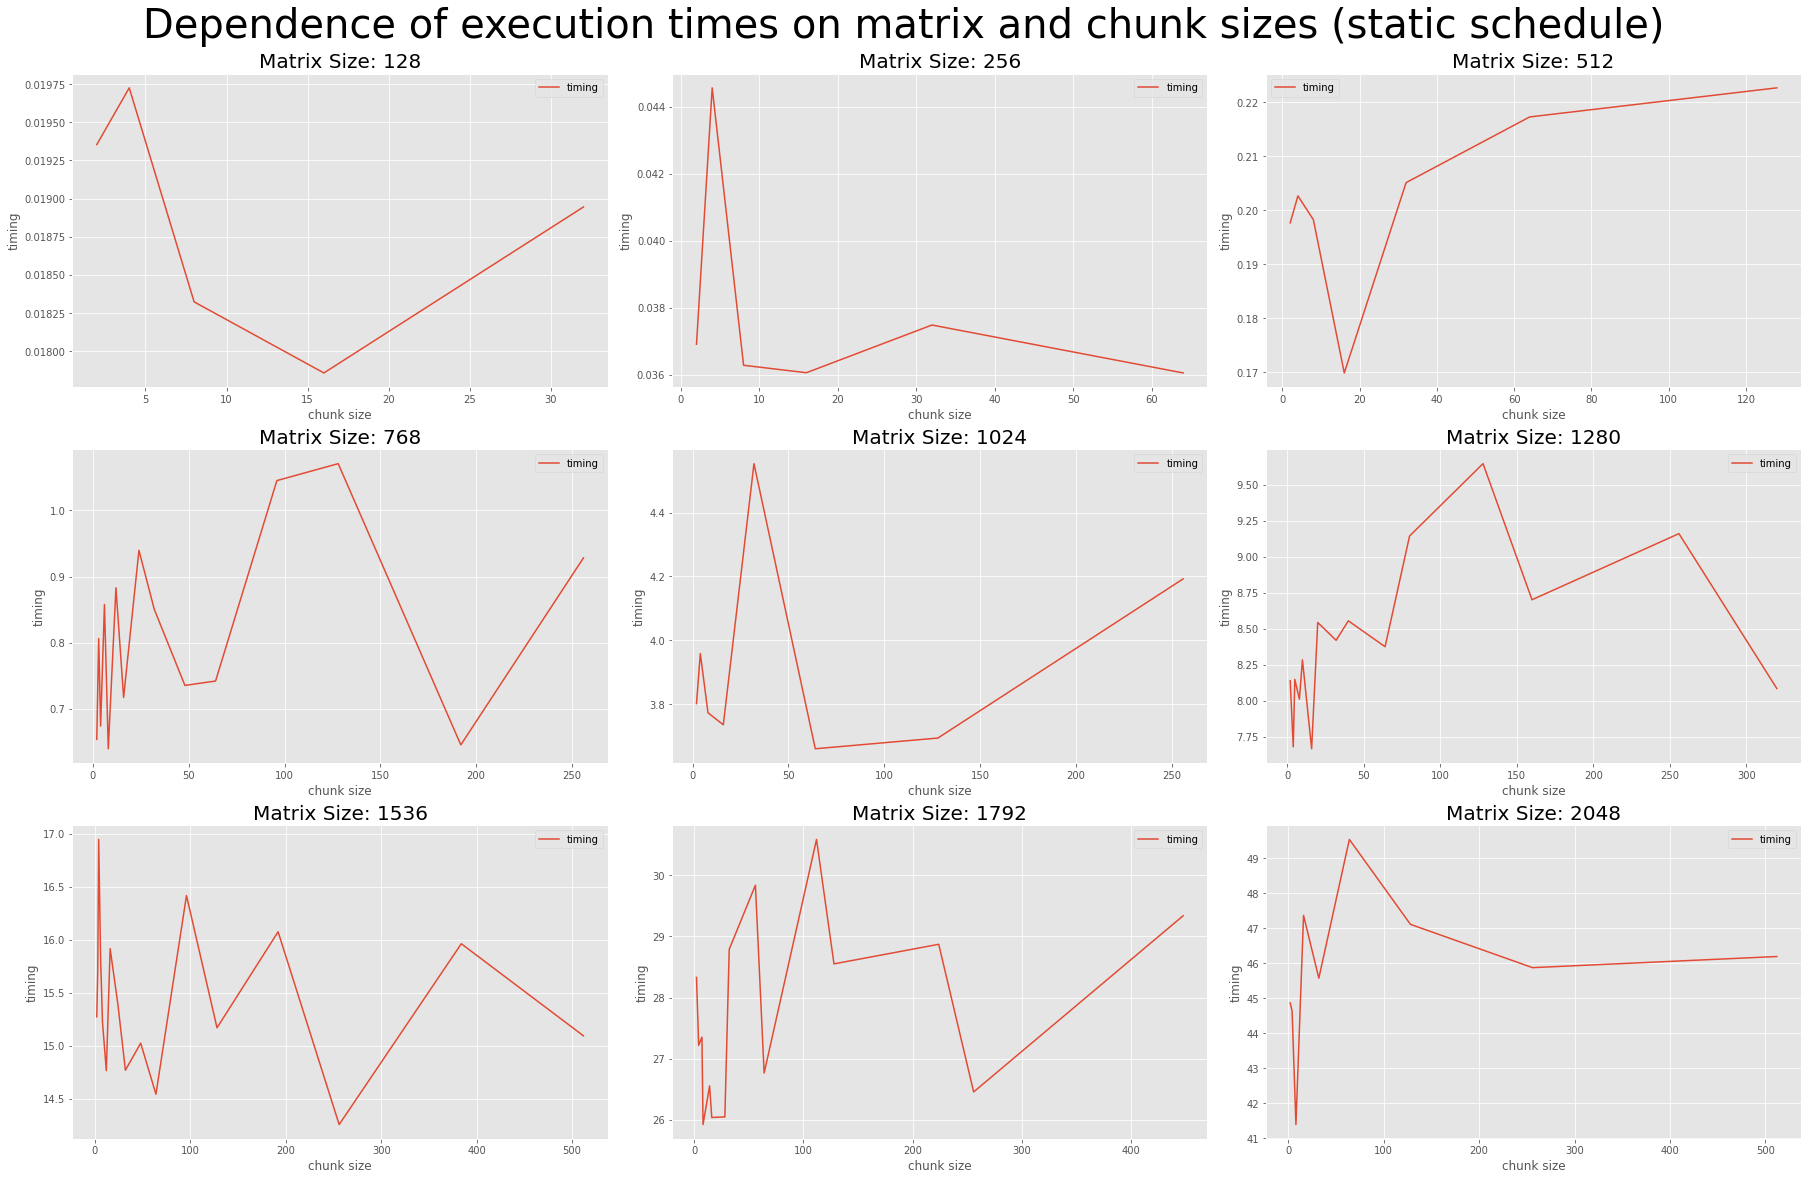

In [20]:
fig = plt.figure(constrained_layout=True, figsize=(25, 25))
fig.suptitle("Dependence of execution times on matrix and chunk sizes (static schedule)", fontsize=40)
spec2 = gs.GridSpec(ncols=3, nrows=5, figure=fig)
sizes = sorted(list(set(parallel['matrix_size'])))
for i, s in enumerate(sizes):
    ax = fig.add_subplot(spec2[i // 3, i % 3])
    static_data = parallel[np.logical_and(parallel['schedule'] == 'static', parallel['matrix_size'] == s)]
    static_data.plot.line(x='chunk size', y=f'timing', ax=ax)
    ax.set_xlabel('chunk size')
    ax.set_ylabel('timing')
    ax.set_title(f'Matrix Size: {s}', fontsize=20)

The variation looks erratic when we change the value of chunk size

## Dynamic schedule

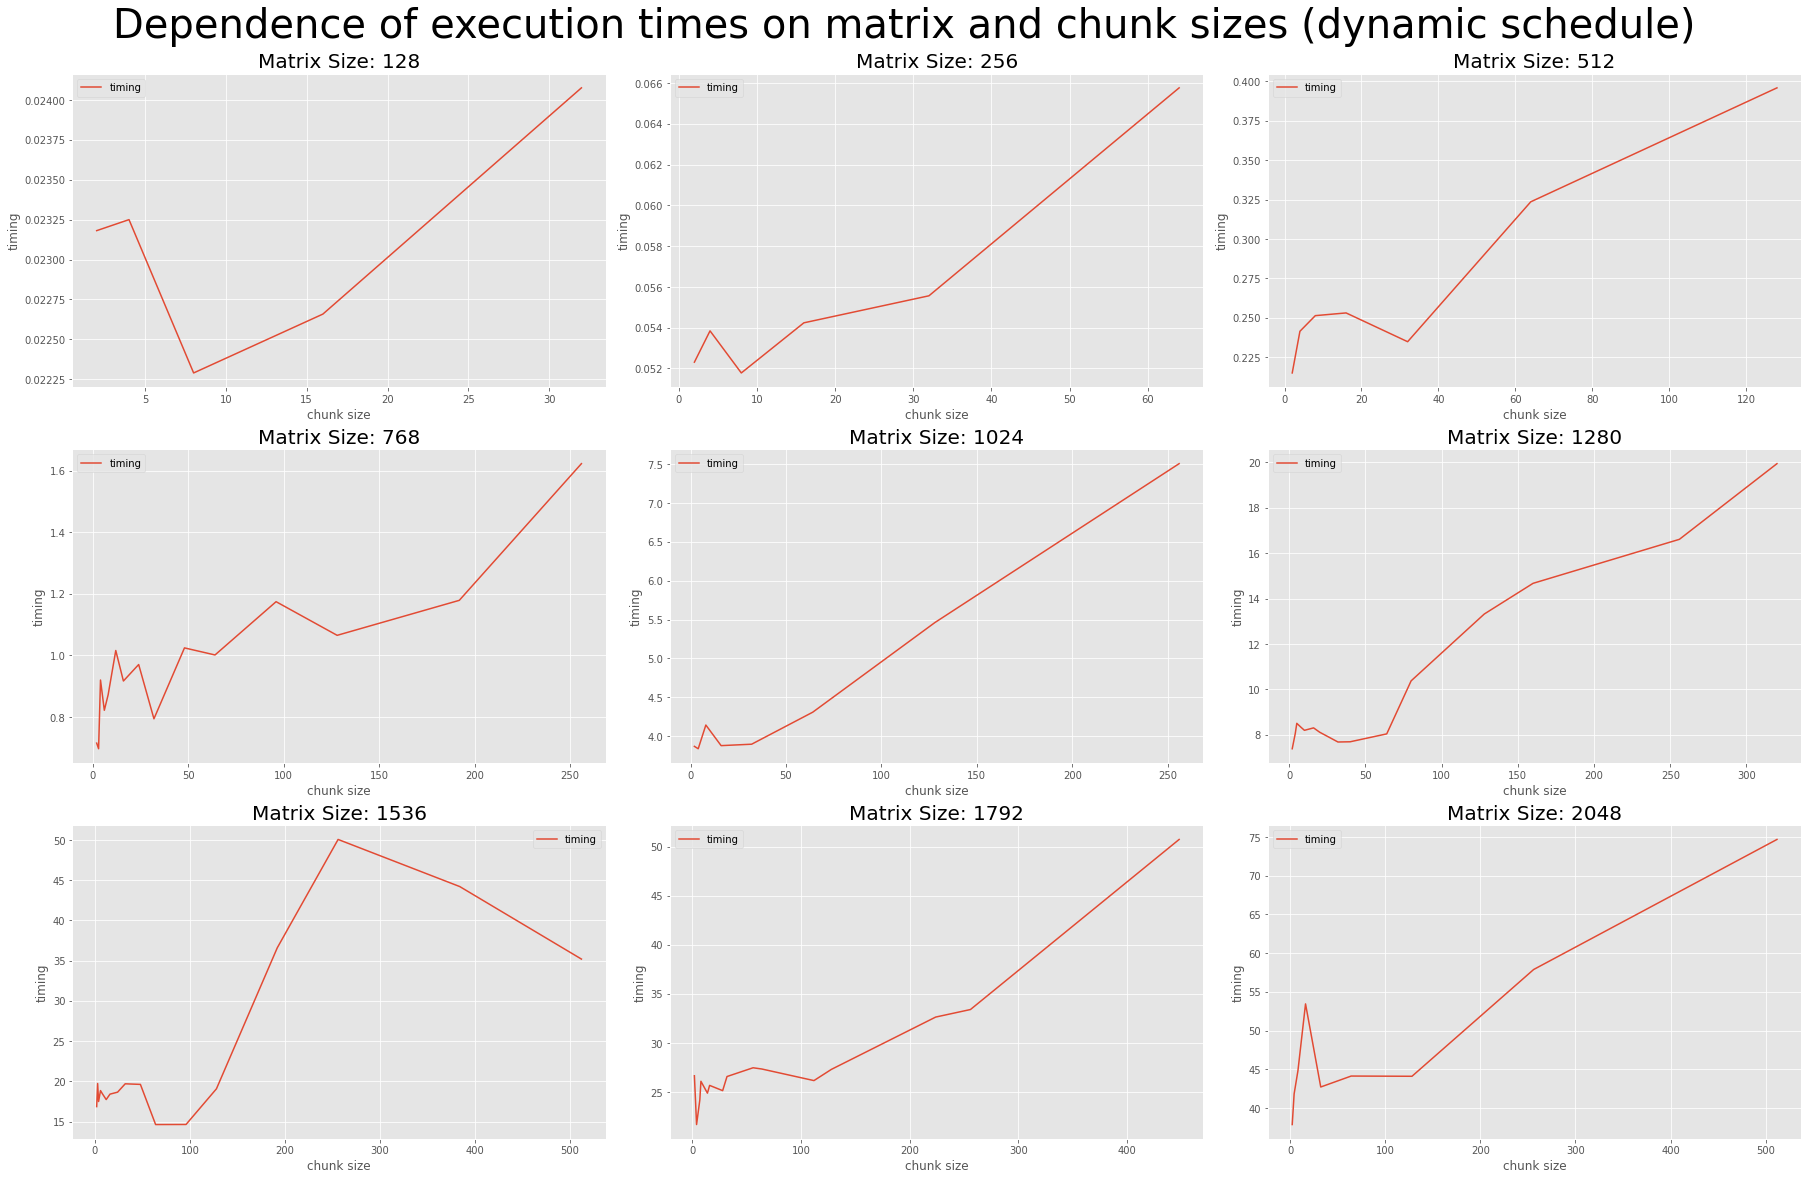

In [21]:
fig = plt.figure(constrained_layout=True, figsize=(25, 25))
fig.suptitle("Dependence of execution times on matrix and chunk sizes (dynamic schedule)", fontsize=40)
spec2 = gs.GridSpec(ncols=3, nrows=5, figure=fig)
sizes = sorted(list(set(parallel['matrix_size'])))
for i, s in enumerate(sizes):
    ax = fig.add_subplot(spec2[i // 3, i % 3])
    static_data = parallel[np.logical_and(parallel['schedule'] == 'dynamic', parallel['matrix_size'] == s)]
    static_data.plot.line(x='chunk size', y=f'timing', ax=ax)
    ax.set_xlabel('chunk size')
    ax.set_ylabel('timing')
    ax.set_title(f'Matrix Size: {s}', fontsize=20)

The graphs generally follow a linear evolution for dynamic schedule. It seems that choosing small chunk size gives better result in general.

## Guided schedule

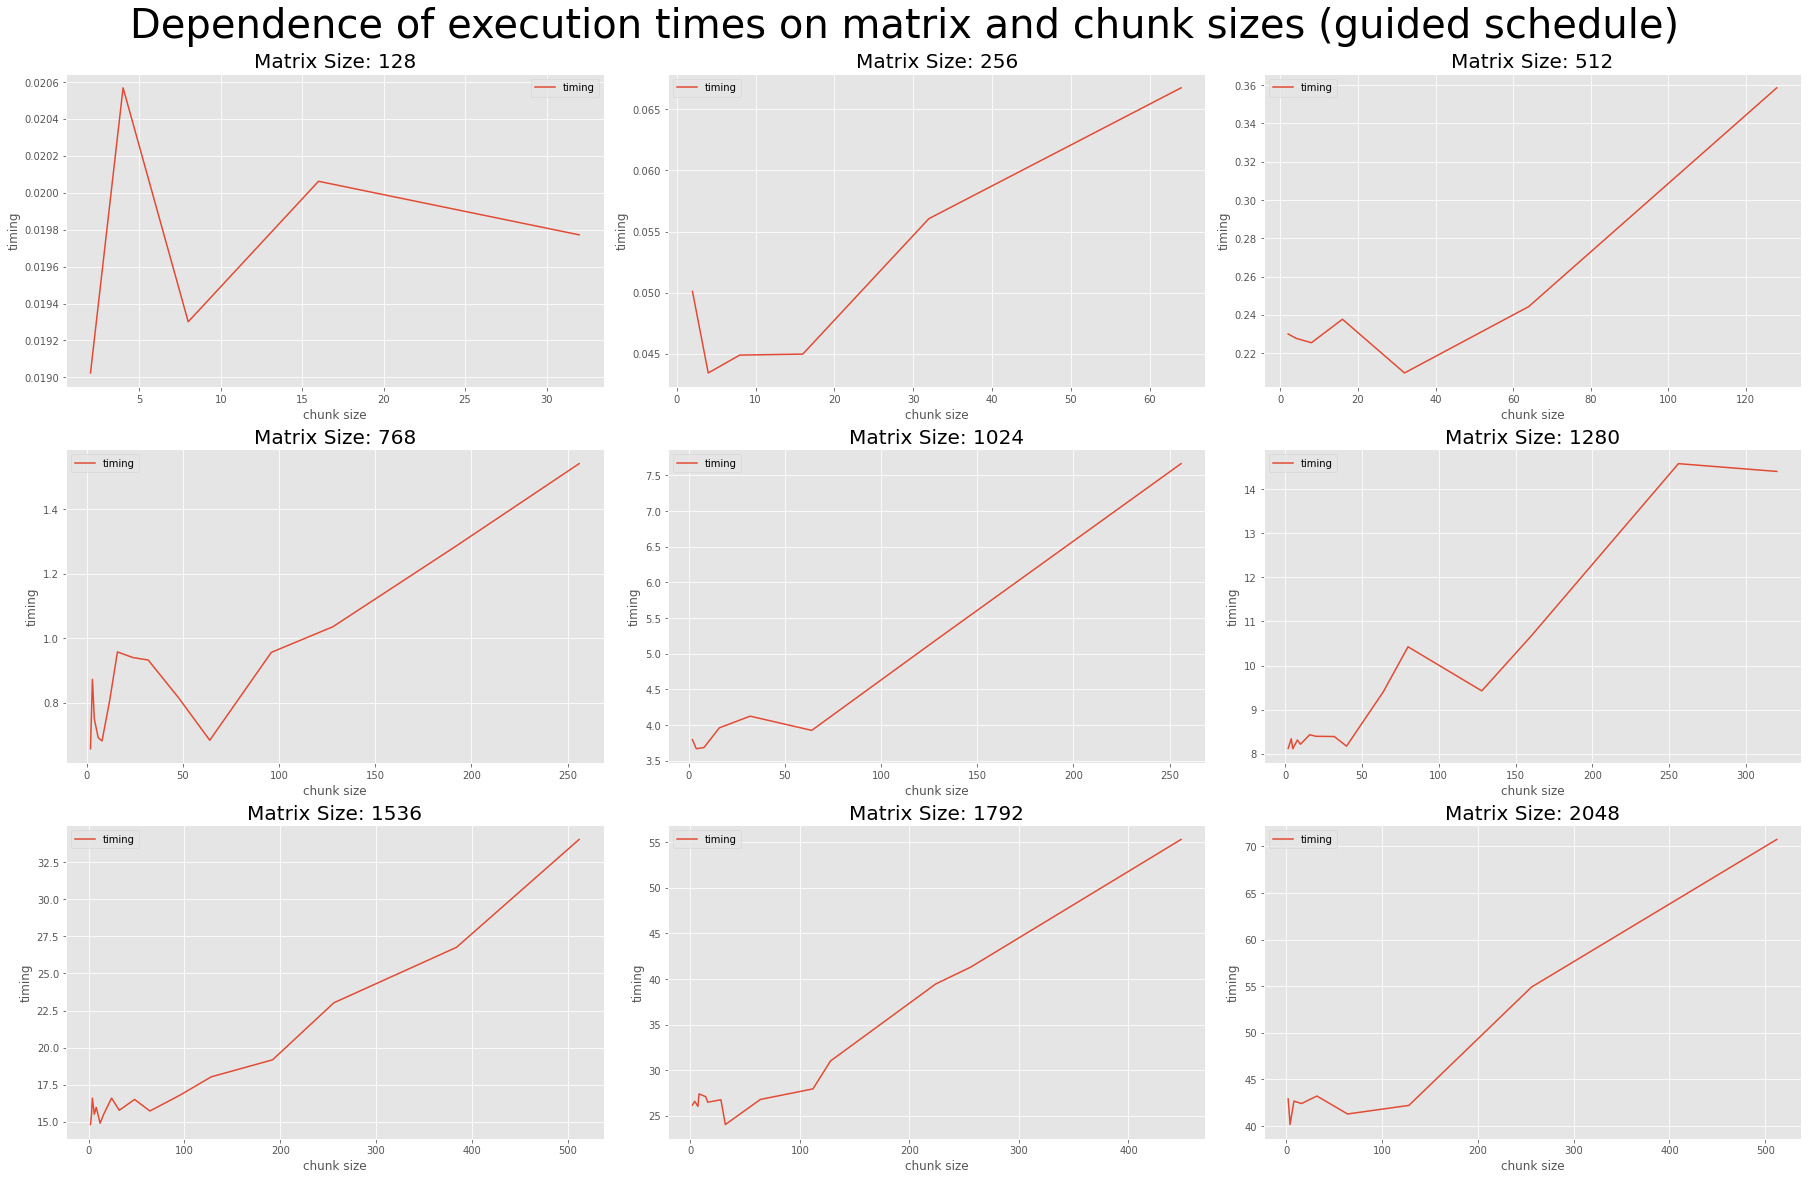

In [22]:
fig = plt.figure(constrained_layout=True, figsize=(25, 25))
fig.suptitle("Dependence of execution times on matrix and chunk sizes (guided schedule)", fontsize=40)
spec2 = gs.GridSpec(ncols=3, nrows=5, figure=fig)
sizes = sorted(list(set(parallel['matrix_size'])))
for i, s in enumerate(sizes):
    ax = fig.add_subplot(spec2[i // 3, i % 3])
    static_data = parallel[np.logical_and(parallel['schedule'] == 'guided', parallel['matrix_size'] == s)]
    static_data.plot.line(x='chunk size', y=f'timing', ax=ax)
    ax.set_xlabel('chunk size')
    ax.set_ylabel('timing')
    ax.set_title(f'Matrix Size: {s}', fontsize=20)

Guided schedule gives result similar to the dynamic one. Evolution is mostly linear and small chunks give better results overall.

In [23]:
best_parallel = {'static': [], 'dynamic': [], 'guided': []}
for schedule in best_parallel:
    static_data = parallel[parallel['schedule'] == schedule]
    sizes = sorted(list(set(static_data['matrix_size'])))
    for s in sizes:
        static_data_m = static_data[static_data['matrix_size'] == s]
        row_min = np.argmin(static_data_m['timing'])
        best_parallel[schedule].append(static_data_m.iloc[row_min])
    
    best_parallel[schedule] = pd.DataFrame(best_parallel[schedule], columns = ['matrix_size', 'schedule', 'chunk size', 'timing']).reset_index(drop=True)

# Speedup over a serial counterpart of the program

Speedup is calculated as follows: 
$$S(m) = \frac{T_{serial}(m)}{T_{parallel}(m)}$$ 
where $m$ is matrix size

For each matrix size $m$, the speedup is calculated using the chunk size giving the best performance

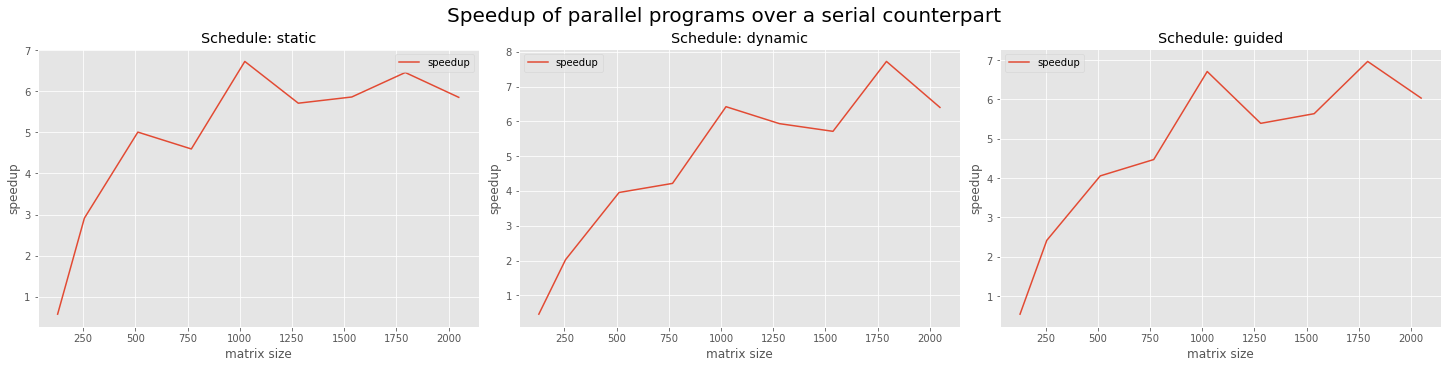

In [24]:
fig = plt.figure(constrained_layout=True, figsize=(20, 5))
fig.suptitle('Speedup of parallel programs over a serial counterpart', fontsize=20)
spec = gs.GridSpec(ncols=3, nrows=1, figure=fig)
for i, schedule in enumerate(best_parallel):
    ax = fig.add_subplot(spec[0, i])
    best_parallel[schedule]['speedup'] = serial['timing'] / best_parallel[schedule]['timing']
    best_parallel[schedule].plot.line(x='matrix_size', y=f'speedup', ax=ax) 
    ax.set_xlabel('matrix size')
    ax.set_ylabel('speedup')
    ax.set_title('Schedule: ' + schedule)

Parallel programs outperforms for matrix for a size $m > 200$.

# Dependence of the execution time on chunk sizes in schedule

## Best chunk size for static schedule

In [25]:
print(best_parallel['static'])
print(serial)


   matrix_size schedule  chunk size     timing   speedup
0          128   static          16   0.017857  0.577275
1          256   static          64   0.036048  2.913216
2          512   static          16   0.169869  5.007057
3          768   static           8   0.639648  4.596926
4         1024   static          64   3.660362  6.726566
5         1280   static          16   7.665756  5.710507
6         1536   static         256  14.255738  5.861631
7         1792   static           8  25.923004  6.457063
8         2048   static           8  41.396349  5.853114
   matrix_size      timing
0          128    0.010308
1          256    0.105016
2          512    0.850544
3          768    2.940415
4         1024   24.621667
5         1280   43.775354
6         1536   83.561879
7         1792  167.386475
8         2048  242.297539


## Best chunk size for dynamic schedule

In [26]:
best_parallel['dynamic']

,matrix_size,schedule,chunk size,timing,speedup
0,128,dynamic,8,0.022289,0.462488
1,256,dynamic,8,0.051782,2.028033
2,512,dynamic,2,0.214986,3.956275
3,768,dynamic,3,0.697145,4.217795
4,1024,dynamic,4,3.834977,6.420291
5,1280,dynamic,2,7.378175,5.933087
6,1536,dynamic,64,14.626963,5.712866
7,1792,dynamic,4,21.682705,7.719815
8,2048,dynamic,2,37.864137,6.399130


## Best chunk size for guided schedule

In [27]:
best_parallel['guided']

,matrix_size,schedule,chunk size,timing,speedup
0,128,guided,2,0.019024,0.541863
1,256,guided,4,0.043434,2.417820
2,512,guided,32,0.209620,4.057551
3,768,guided,2,0.657356,4.473093
4,1024,guided,4,3.668877,6.710955
5,1280,guided,5,8.116453,5.393409
6,1536,guided,2,14.818655,5.638965
7,1792,guided,32,24.024544,6.967311
8,2048,guided,4,40.147863,6.035129


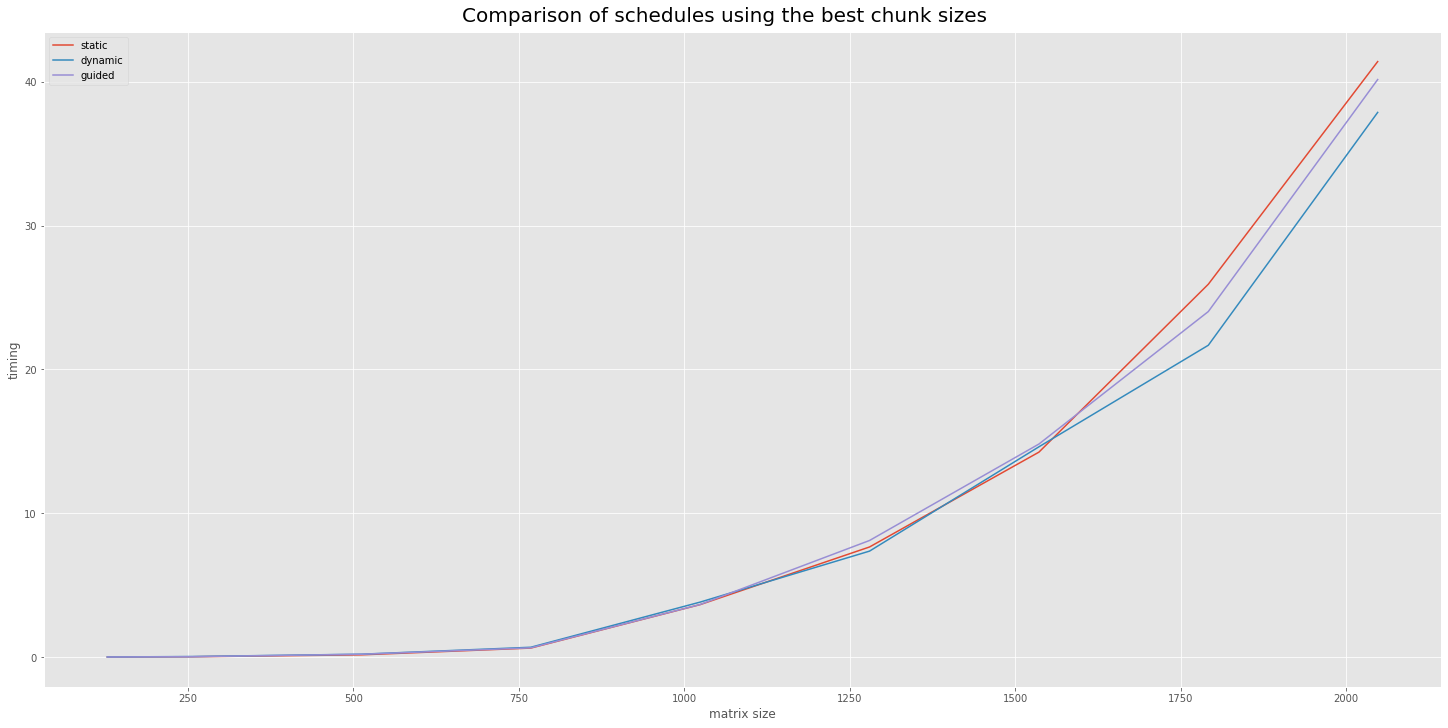

In [28]:
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
fig.suptitle('Comparison of schedules using the best chunk sizes', fontsize=20)
spec = gs.GridSpec(ncols=1, nrows=1, figure=fig)
ax = fig.add_subplot(spec[0, 0])
for i, schedule in enumerate(best_parallel):
    best_parallel[schedule].plot.line(x='matrix_size', y=f'timing', ax=ax) 
    ax.set_xlabel('matrix size')
    ax.set_ylabel('timing')
ax.legend(best_parallel.keys())

For large matrix, guided schedule seems to be better than dynamic (difference of ~3s) and dynamic is better than static (difference ~1s)